In [23]:

from multiprocessing import Pool
from tqdm import tqdm
from spacy.lang.en import English
import gensim.corpora as corpora
from gensim.models import LdaMulticore
import multiprocessing as mp
import json
import re
import numpy as np
import pandas as pd
from pprint import pprint
import pickle
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from nltk.corpus import wordnet as wn
#nltk.download('stopwords')
#nltk.download('wordnet')
# spacy for lemmatization
import spacy
from spacy.lang.en import English
parser = English()

#Sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
# Plotting tools

import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


In [24]:
def tokenize(doc):
    tokens = doc.split(" ")
    tokens = [word for word in tokens if len(word.strip())>2]
    return tokens

print("Loading tech corpus")
with open("../data/tech_review_word_corpus.pkl","rb") as f:
    tech_review_corpus = pickle.load(f)
    
reviews = pd.DataFrame(tech_review_corpus).review.tolist()
print("Tokenize the corpus")

with open(( "../data/stop_words.json"), "r") as f:
    stop_words = json.load(f)

vectorizer = CountVectorizer( min_df = 5,max_df=.90, tokenizer=tokenize, stop_words=stop_words, ngram_range=(1, 2))

np.random.seed(100)

Loading tech corpus
Tokenize the corpus


In [25]:
len(reviews)

45251

## Sampling

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test= train_test_split(reviews,test_size=0.01, random_state=100)

In [27]:
print(len(X_train))
print(len(X_test))

44798
453


In [28]:
#pd.DataFrame(X_test).to_csv("../data/test_review.csv")

In [29]:
X = vectorizer.fit_transform(X_train)
print("Total Vocab Size", len(vectorizer.vocabulary_))

Total Vocab Size 28806


In [90]:
from gensim.corpora.dictionary import Dictionary
def vect2gensim(vectorizer, dtmatrix):
     # transform sparse matrix into gensim corpus and dictionary
    corpus_vect_gensim = gensim.matutils.Sparse2Corpus(dtmatrix, documents_columns=False)
    dictionary = Dictionary.from_corpus(corpus_vect_gensim,
        id2word=dict((id, word) for word, id in vectorizer.vocabulary_.items()))

    return (corpus_vect_gensim, dictionary)
corpus, id2word = vect2gensim(vectorizer, X)

In [13]:
#final_lda_model = LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           chunksize=100,
                                           workers = 2,
                                           passes=10,
                                           alpha="symmetric",
                                           eta=0.91,
                                           per_word_topics=True)

In [15]:
#final_lda_model.save('../results/word-k8-gensim-lda3model')

In [31]:
from gensim import  models

final_lda_model =  models.LdaModel.load('../results/word-k8-gensim-lda.model')

In [32]:
# Select the model and print the topics
optimal_model = final_lda_model
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))

[(0,
  '0.042*"work" + 0.027*"part" + 0.025*"enjoy" + 0.021*"job" + 0.016*"hard" + '
  '0.012*"part job" + 0.011*"learn" + 0.011*"help" + 0.011*"time" + '
  '0.010*"management" + 0.009*"hard part" + 0.009*"always" + 0.009*"typical" + '
  '0.009*"co-worker" + 0.008*"enjoy part" + 0.007*"customer" + 0.006*"enjoy '
  'work" + 0.006*"issue" + 0.005*"challenge" + 0.005*"get" + 0.005*"make" + '
  '0.004*"people" + 0.004*"typical work" + 0.004*"call" + 0.004*"need" + '
  '0.004*"fun" + 0.004*"every" + 0.004*"great" + 0.004*"project" + '
  '0.004*"manager"'),
 (1,
  '0.036*"project" + 0.029*"good" + 0.024*"salary" + 0.015*"depend" + '
  '0.014*"less" + 0.009*"hike" + 0.009*"job" + 0.008*"get" + 0.008*"onsite" + '
  '0.007*"security" + 0.007*"job security" + 0.007*"growth" + '
  '0.006*"opportunity" + 0.006*"fresher" + 0.006*"low" + 0.006*"management" + '
  '0.005*"much" + 0.005*"con" + 0.005*"depend project" + 0.005*"base" + '
  '0.005*"onsite opportunity" + 0.004*"compare" + 0.004*"bad" + 0.0

In [21]:
lda_display = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

In [18]:
aspect = {}
for t in range(0, optimal_model.num_topics):
    aspect['topic {}: '.format(t)] = [v[0] for v in optimal_model.show_topic(t, 50)]

In [19]:
with open("../results/gensim/word-gensim-lda-topic-k-8.json", "w") as f:
                json.dump(aspect, f)

In [40]:
with open("../data/all_reviews.pkl","rb") as f:
    reviews_ = pickle.load(f)
    
job_filter = pd.read_csv("../data/filter_job_titles.csv")

job_filters = job_filter.clean_job_title.tolist()
idx = (reviews_.language == "en")
reviews_ = reviews_.loc[idx,:]

idx = (reviews_.clean_job_title.isin(job_filters))
reviews_ = reviews_.loc[idx,:].reset_index()

print(reviews_.shape)
#display(reviews_.head())


(45251, 16)


In [41]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=reviews):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=final_lda_model, corpus=corpus, texts=X_train)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()

df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

#df_dominant_topic["Review"] = reviews_["review"] 
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.5206,"work, good, place, balance, life, culture, env...",wonderful work culture management be very frie...
1,1,4.0,0.4500,"work, management, people, get, employee, great...",flexible timing you can start your work at any...
2,2,5.0,0.7117,"work, good, place, balance, life, culture, env...",cognizant be a good company if you want hike i...
3,3,1.0,0.6549,"project, good, salary, depend, less, hike, job...",i have be work for tata consultancy service fu...
4,4,3.0,0.9663,"system, development, software, support, applic...",• analysis of specification provide by client ...
5,5,3.0,0.4709,"system, development, software, support, applic...",tsys be a good company their all policy be for...
6,6,6.0,0.3905,"learn, work, good, lot, technology, place, exp...",love my job of identity and access management ...
7,7,0.0,0.9125,"work, part, enjoy, job, hard, part job, learn,...",* typical day at work* what you learned* manag...
8,8,6.0,0.4970,"learn, work, good, lot, technology, place, exp...",it 's a place to explore and dive into coding ...
9,9,5.0,0.4175,"work, good, place, balance, life, culture, env...",it appreciate the effort of employee in variou...


In [42]:
with open("tech_review_with_topics.pkl","wb") as f:
    pickle.dump(df_dominant_topic, f)

In [27]:
df_dominant_topic.groupby('Dominant_Topic').size()

Dominant_Topic
0.0     5423
1.0     2530
2.0       73
3.0     3337
4.0    11273
5.0    10622
6.0     8895
7.0     2645
dtype: int64

In [149]:
test_x = vectorizer.fit_transform(X_test)
test_corpus = [id2word.doc2bow(text) for text in list(map(vectorizer.build_tokenizer(),X_test))]

In [151]:

df_topic = format_topics_sentences(ldamodel=final_lda_model, corpus=test_corpus, texts=X_test)
df_topic.dropna(how='any',inplace=True)
# Format
test_df_dominant_topic = df_topic.reset_index()

test_df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


In [162]:
for i in range(10):
    print('\x1b[0;33;40m' + 'Original Review:' + '\x1b[0m')
    pprint(test_df_dominant_topic["Text"][i])
    print("Topic:",int(test_df_dominant_topic['Dominant_Topic'][i]))
    print('\x1b[0;33;40m' + "Most Ferequent words:" + '\x1b[0m')
    pprint(test_df_dominant_topic['Keywords'][i])
    print("*"*100)

Original Review:
('nice to work here company environment be good i learn new thing from this '
 'company in tech mahindra work culture be good i never find the hard part of '
 'a job in this company')
Topic: 0
Most Ferequent words:
'work, part, enjoy, job, hard, part job, learn, help, time, management'
****************************************************************************************************
Original Review:
('accenture a a company be quite good however some project and people be '
 "really sick if you get into any such project that 's it end of life "
 'management be useless they only bother about their profit only if you get '
 'into project that have onsite will you be able to be a little happy')
Topic: 4
Most Ferequent words:
"work, management, people, get, employee, great, n't, job, year, manager"
****************************************************************************************************
Original Review:
('it be a great place to work i learn a lot about the fina

### The most representative sentence for each topic¶

In [92]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9873,"work, part, enjoy, job, hard, part job, learn, help, time, management",a typical day at work would be first to check the computer screen for any call that need to be r...
1,1.0,0.9687,"project, good, salary, depend, less, hike, job, get, onsite, security",good for fresher good project well onsite opportunity bad compensate a per market standard good ...
2,2.0,0.5712,"many, encourage, learn many, chance, many thing, work/life, work/life balance, mahindra, get cha...",in ibm we have many volunteer activity and club event more than that we have your learn a learni...
3,3.0,0.9960,"system, development, software, support, application, work, project, use, test, client",• involve in complete life cycle of software development include design development test and emp...
4,4.0,0.9950,"work, management, people, get, employee, great, n't, job, year, manager",my experience with hcl be not a very good one very poor communication i be offer a job full time...
5,5.0,0.9810,"work, good, place, balance, life, culture, environment, great, good work, management",good good it pretty good work culture it pretty good work life balance it pretty good pay struct...
6,6.0,0.9861,"learn, work, good, lot, technology, place, experience, thing, get, great",i be fortunate to start my career in tc i get to learn a lot and work across 7 different project...
7,7.0,0.9757,"train, provide, opportunity, employee, growth, skill, organization, technology, service, grow",tata consultancy service limit tc be an indian multinational information technology it service b...


## Frequency Distribution of Word Counts in Documents

In [43]:
with open("tech_review_with_topics.pkl",'rb') as f:
    df_dominant_topic = pickle.load(f)


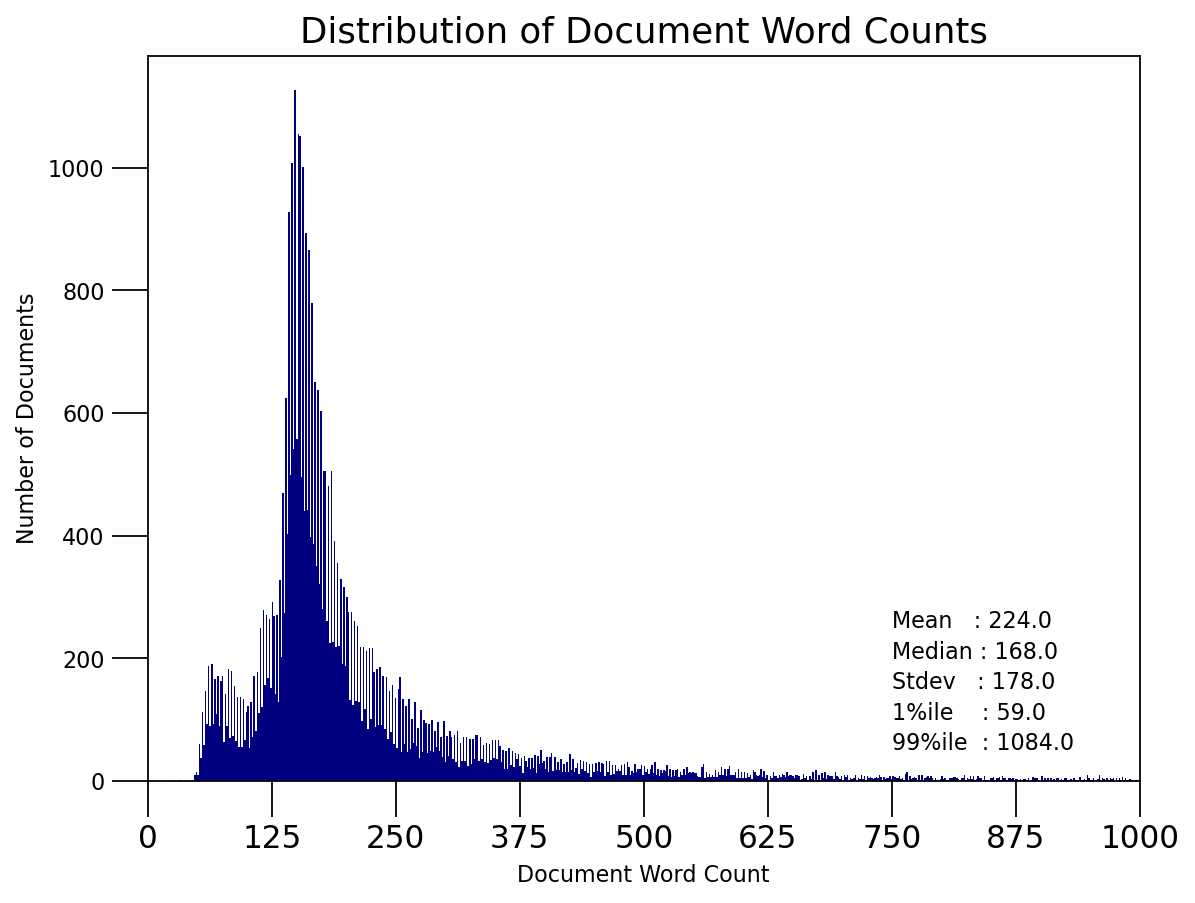

In [203]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(8,6), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 250, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  200, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  150, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  100, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  50, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9),fontsize=14)
plt.title('Distribution of Document Word Counts', fontdict=dict(size=16))
plt.show()

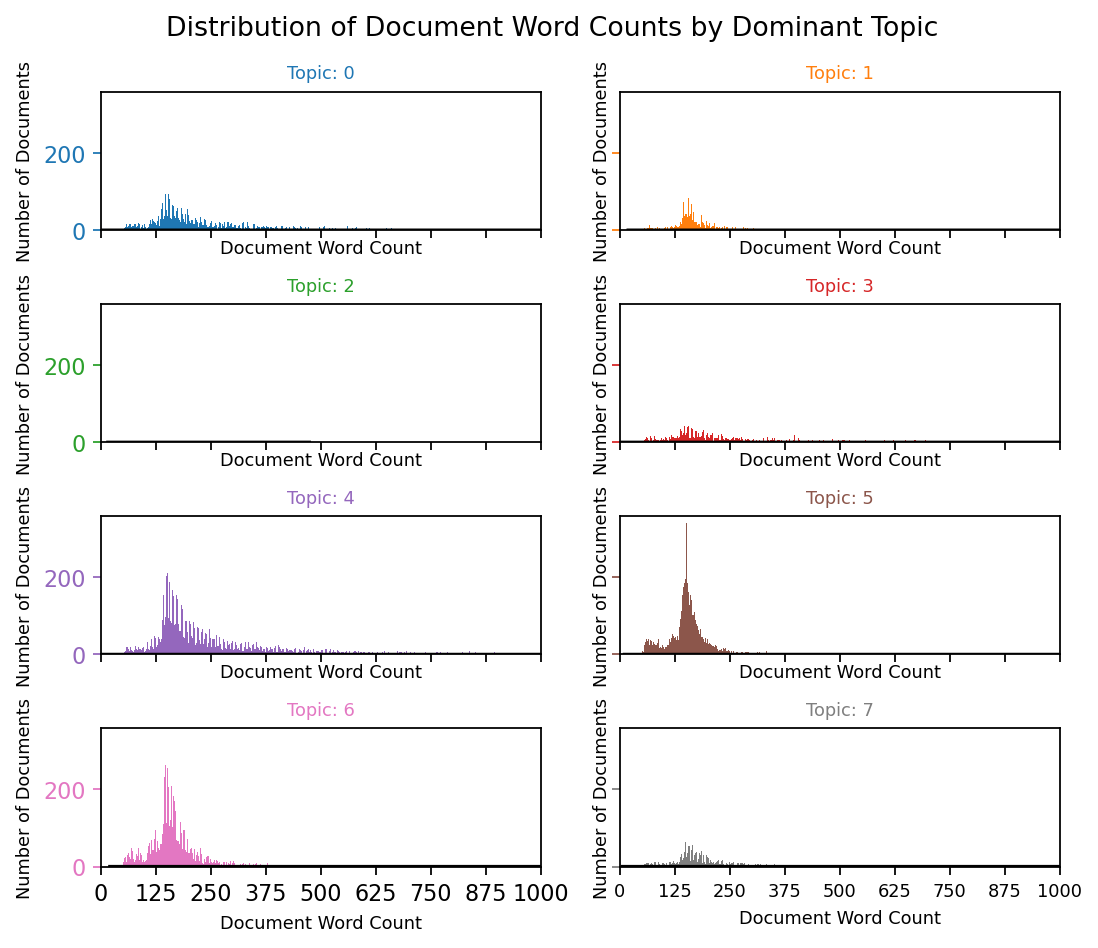

In [250]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(4,2,figsize=(7,6), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax)
    ax.set(xlim=(0, 1000))
    ax.set_xlabel('Document Word Count',fontsize=8)
    ax.set_ylabel('Number of Documents',fontsize=8)
    ax.set_title('Topic: '+str(i), fontdict=dict(size=8, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9),fontsize=8)
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=12)
plt.show()

## Word Clouds of Top N Keywords in Each Topic

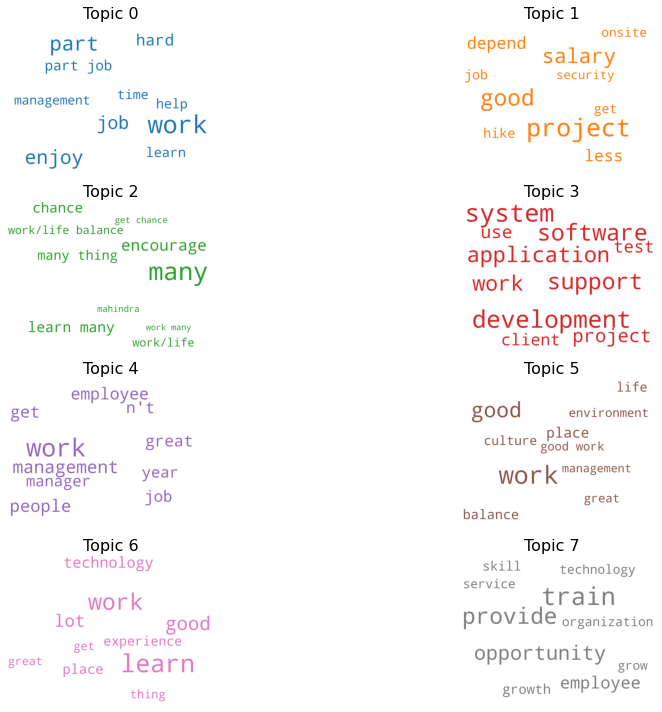

In [179]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = final_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(16,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Word Counts of Topic Keywords

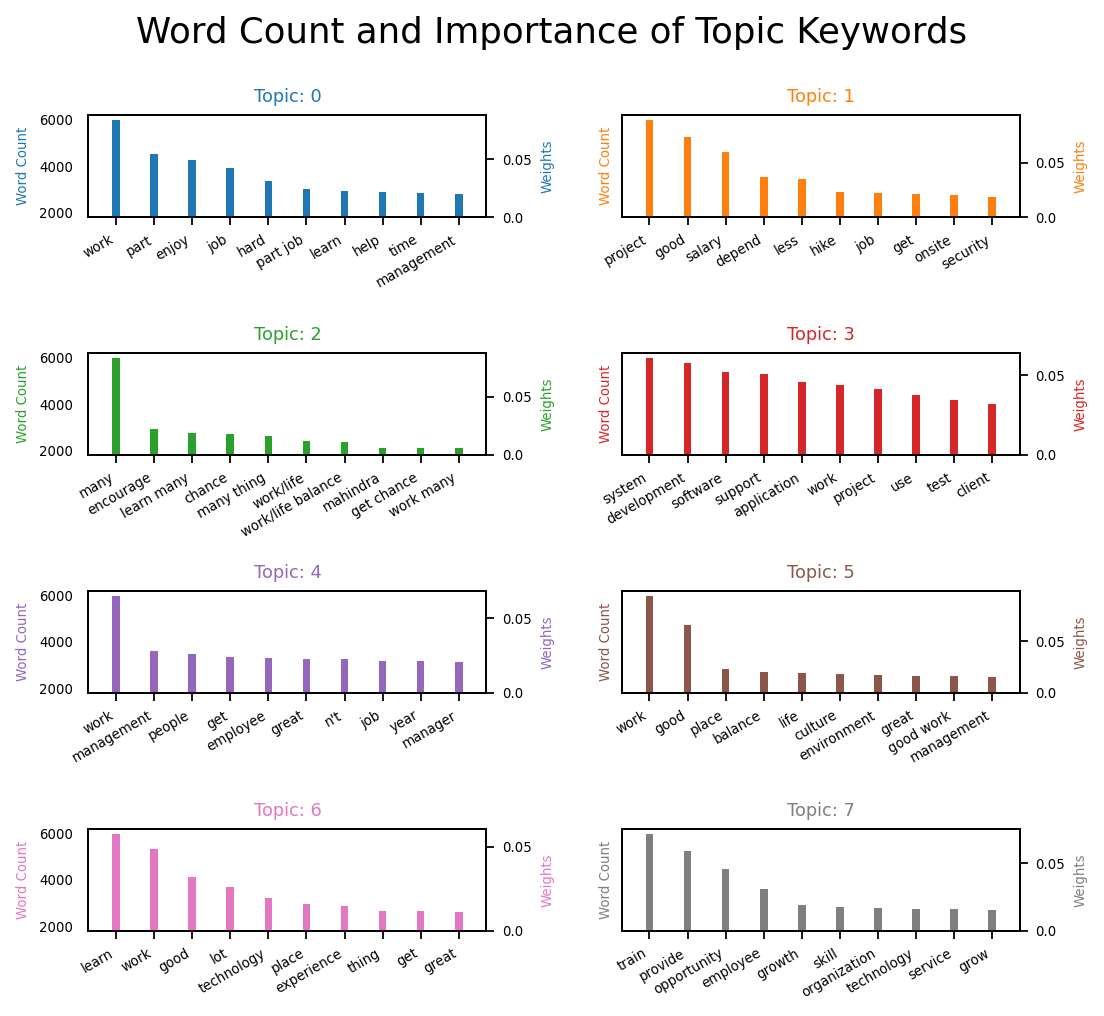

In [238]:
from collections import Counter
topics = final_lda_model.show_topics(formatted=False)
data_flat = [w for w_list in X_train for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(7,6), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2)
    ax_twin.set_ylabel('Weights', color=cols[i], fontsize=6)
    ax.set_ylabel('Word Count', color=cols[i], fontsize=6)
    ax_twin.set_yticklabels(np.arange(0, 0.1,0.05),fontsize=6); ax.set_yticklabels(range(0, 10000,2000),fontsize=6)
   
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=8)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30,  fontsize=6,horizontalalignment= 'right')
    

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=16, y=1.05)    
plt.show()

## Generate topic label

In [164]:
topic_term = pyLDAvis.gensim._extract_data(optimal_model, corpus, id2word)
    

In [165]:
from tmtoolkit.bow.bow_stats import doc_lengths
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words

topic_labels = generate_topic_labels_from_top_words(
    topic_term['topic_term_dists'],
    topic_term['doc_topic_dists'],
    topic_term['doc_lengths'],
    np.array(topic_term['vocab']),
    lambda_=2  
)

topic_labels[:10]   # showing only the first 5 topics here

array(['1_work_job_learn', '2_good_project_job',
       '3_many_encourage_learn many', '4_work_management_project',
       '5_work_management_good', '6_work_good_place', '7_work_good_learn',
       '8_opportunity_employee_train'], dtype='<U28')

## Sentence Chart Colored by Topic

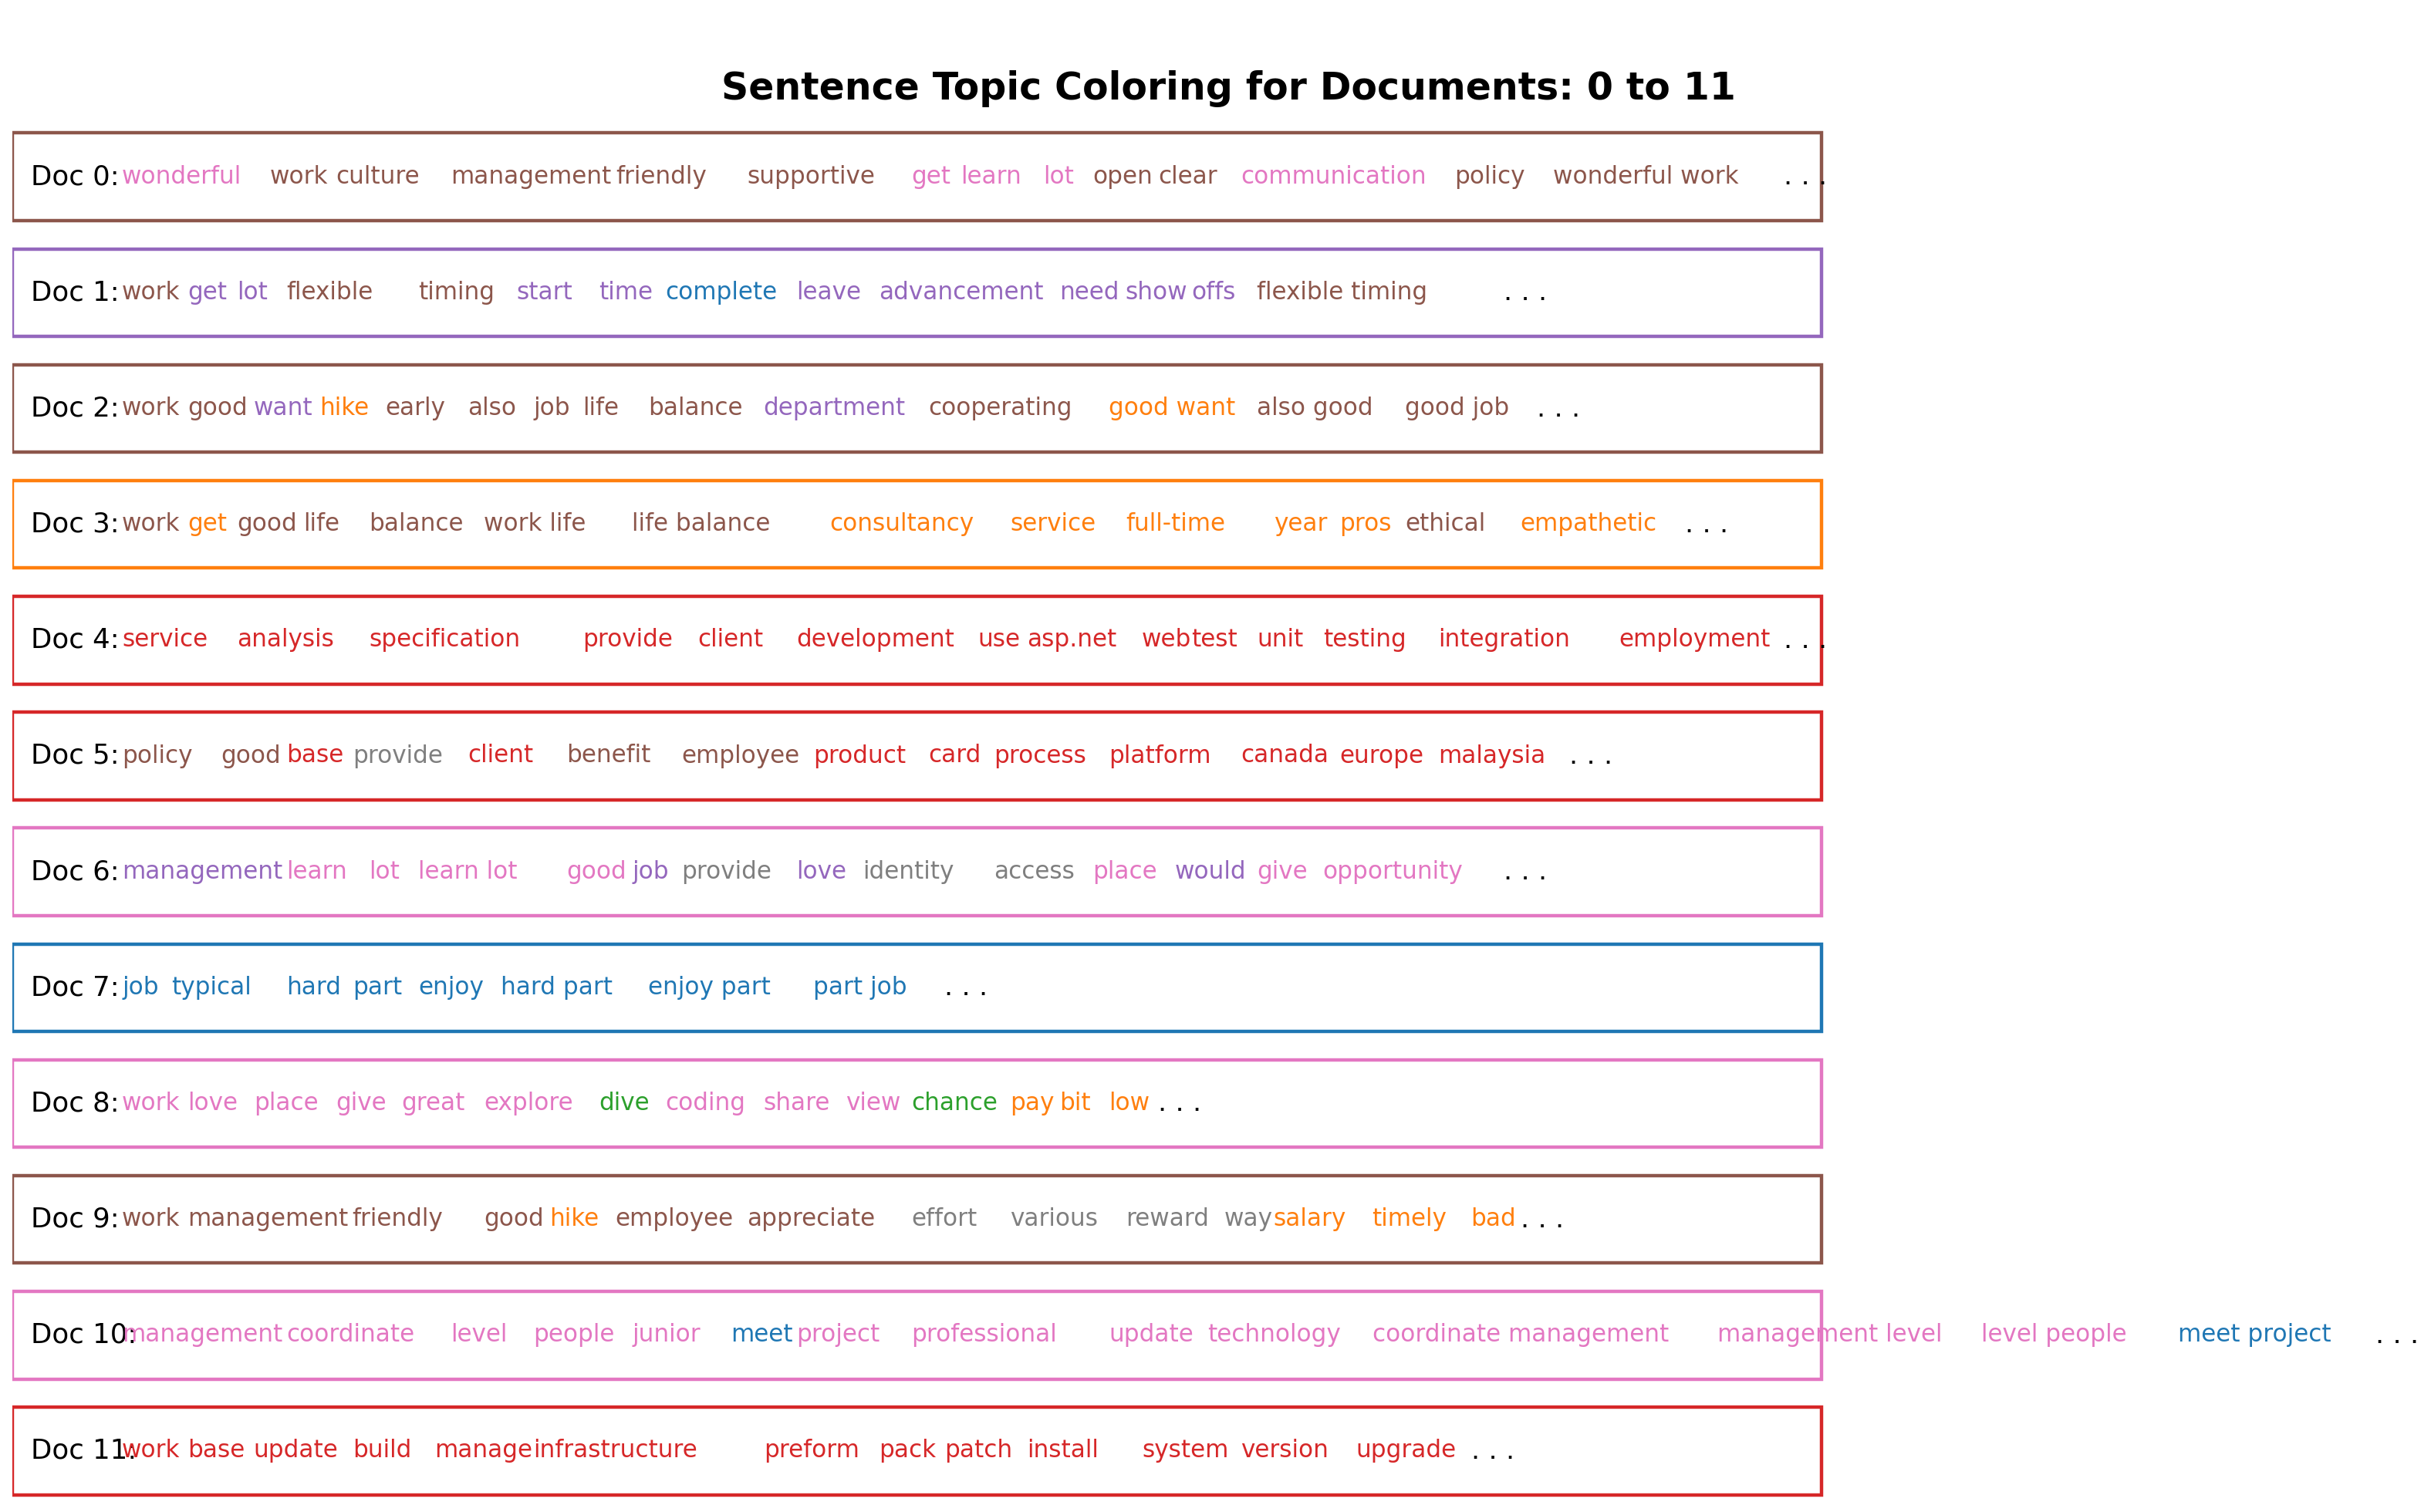

In [163]:
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=final_lda_model, corpus=corpus, start = 0, end = 13):
    corp = list(corpus)[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=200)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            verticalalignment='center',
                            fontsize=14, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=200)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

##  What are the most discussed topics in the documents?

In [168]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = list(corpus)[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=final_lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in final_lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

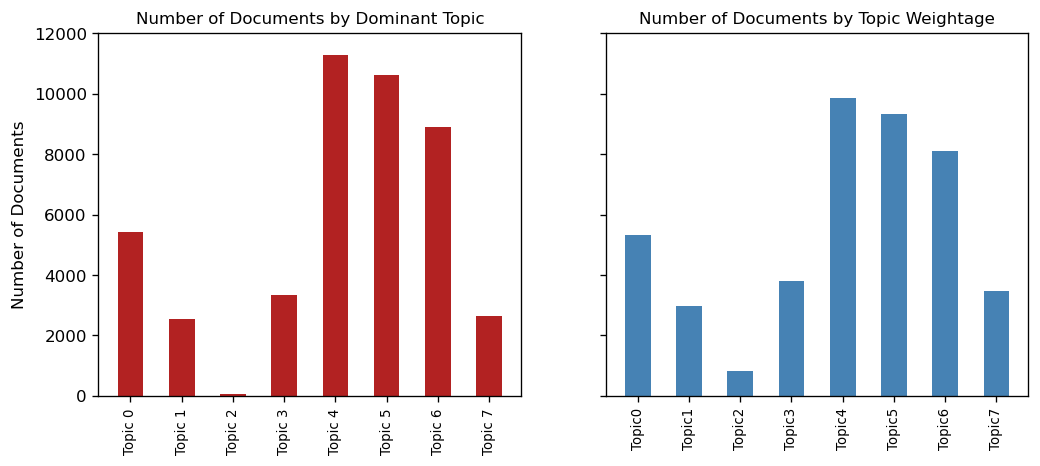

In [248]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)
# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic' + str(x))
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 12000)
ax1.set_xticklabels(['Topic ' + str(x) for x in range(8)] ,fontsize=8, rotation=90)
# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
plt.xticks(fontsize=8, rotation=90)
plt.show()

### Sklearn Topic Modeling

In [52]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV 


In [53]:

lda = LatentDirichletAllocation(
                learning_method="batch",
                random_state=100,
                n_components=7,
                doc_topic_prior=0.01,
                topic_word_prior=0.31,
                n_jobs=-2
            )
lda.fit(X)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=0.01,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=7, n_jobs=-2,
                          perp_tol=0.1, random_state=100, topic_word_prior=0.31,
                          total_samples=1000000.0, verbose=0)

In [54]:
def print_topics(model, vectorizer, top_n=50):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
 
print("LDA Model:")
print_topics(lda, vectorizer)
print("=" * 20)

LDA Model:
Topic 0:
[('•', 2152.3043183731656), ('development', 1730.0918149780796), ('work', 1473.2847012084758), ('system', 1457.0119540512298), ('use', 1425.1357544326597), ('application', 1391.1172856916562), ('support', 1212.6857484482955), ('software', 1169.3874339943602), ('test', 917.8518795823762), ('issue', 879.8888915237427), ('project', 874.5352259273773), ('server', 776.6539095713795), ('design', 766.4158022574471), ('network', 754.6627604125773), ('user', 744.0942142497814), ('client', 674.6770678451837), ('experience', 650.6240976933344), ('business', 598.0986940791116), ('implement', 588.7212301902206), ('&', 574.7780458279402), ('database', 557.4207393155214), ('management', 556.1743915970684), ('requirement', 556.0817790424478), ('process', 544.420606179033), ('report', 542.8321989617361), ('involve', 524.7963207415515), ('code', 489.04390144066673), ('service', 467.07465160550277), ('create', 463.18197149801205), ('developer', 441.6234514420656), ('manage', 429.87590

[('work', 10392.353177745086), ('great', 5370.733354160755), ('employee', 2715.459069728282), ('benefit', 2467.7090289603602), ('place', 2390.7375114337424), ('management', 2043.3726178089642), ('place work', 1536.6564625462163), ('environment', 1445.1097338282866), ('hour', 1349.2187289460333), ('balance', 1329.1694301086848), ('culture', 1224.420864097882), ('time', 1065.5473205088151), ('pay', 1042.8836855528596), ('great place', 1015.4643868322244), ('well', 1005.0291481525225), ('people', 997.9322165042648), ('life', 904.2763668001636), ("'s", 885.4578887642748), ('flexible', 882.3676588851167), ('good', 870.698314616632), ('great work', 858.3601608209251), ('opportunity', 833.5919583938993), ('care', 764.4202211100444), ('need', 763.6882229722637), ('home', 698.561504992571), ('work environment', 678.2519329026813), ('like', 659.0393635460014), ('make', 649.1010295495588), ('advancement', 595.5452098553545), ('one', 588.122356651096), ('excellent', 587.908569696159), ('lot', 572.

In [56]:
aspect = {}
for idx, topic in enumerate(lda.components_):
    aspect['Aspect {0}'.format(str(idx))] = [vectorizer.get_feature_names()[i]
                                                         for i in topic.argsort()[:-100 - 1:-1]]

with open("../results/Sklearn-LDA/sklearn-word-lda-topic-k-7-a-0.01-b-0.31.json", "w") as f:
    json.dump(aspect, f)

TypeError: list indices must be integers or slices, not str

In [ ]:
# Build a Non-Negative Matrix Factorization Model
nmf = NMF(n_components=7
                  ,init='nndsvd'
                 ,random_state=100,
                 alpha=0.61)

nmf.fit(X)


In [ ]:
print("NMF Model:")
print_topics(nmf, vectorizer)
print("=" * 20)

In [ ]:
spect = {}
for idx, topic in enumerate(nmf.components_):
    aspect['Aspect {0}'.format(str(idx))] = {vectorizer.get_feature_names()[i]
                                                         for i in topic.argsort()[:-100 - 1:-1]}

with open("../results/Sklearn-LDA/sklearn-word-nmf-topic-k-7-a-0.61.json", "w") as f:
    json.dump(aspect, f)